<a href="https://colab.research.google.com/github/Jderrick97/Colab/blob/main/Assingment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
!pip install py7zr
import py7zr

import py7zr
with py7zr.SevenZipFile("/content/drive/MyDrive/Colab Notebooks/data.7z", mode='r') as z:
    z.extractall()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=1),  # corrected layer
            nn.Sigmoid())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


# Define the dataset class
class DogsCatsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.file_names = os.listdir(root_dir)

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.file_names[idx])
        image = Image.open(img_name).convert('L')  # convert to grayscale
        image = transforms.Resize((28, 28))(image)  # resize to 28x28
        image = transforms.Resize((56, 56))(image)  # upscale to 56x56
        if self.transform:
            image = self.transform(image)
        return image, image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((56, 56)),
    transforms.ToTensor()])

# Create the datasets and dataloaders
train_dataset = DogsCatsDataset('train', transform=transform)
test_dataset = DogsCatsDataset('test1', transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Create the model and the optimizer
autoencoder = Autoencoder()
optimizer = optim.Adadelta(autoencoder.parameters())

# Train the model
for epoch in range(1):
    for i, (inputs, _) in enumerate(train_dataloader):
        noisy_inputs = inputs + 0.5 * torch.randn(inputs.size())  # add random noise
        noisy_inputs = torch.clamp(noisy_inputs, 0., 1.)  # clip to [0, 1]
        optimizer.zero_grad()
        outputs = autoencoder(noisy_inputs)
        loss = nn.functional.binary_cross_entropy(outputs, inputs)
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print(f'Epoch {epoch+1}, batch {i+1}, loss: {loss.item():.4f}')



Epoch 1, batch 1, loss: 0.6908
Epoch 1, batch 101, loss: 0.6907


In [ ]:
# Save the model
torch.save(autoencoder.state_dict(), 'Autoencoder.pth')


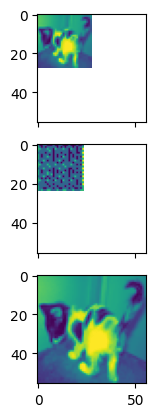

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_tensor, to_pil_image

# Load the saved PyTorch model
model = Autoencoder()
model.load_state_dict(torch.load('Autoencoder.pth'))
model.eval()

# Load the test image and preprocess it
orig_image = Image.open('test1/12000.jpg').convert('L')
resized_image = orig_image.copy().resize((28, 28))
input_tensor = to_tensor(resized_image).unsqueeze(0)

# Generate the output image
with torch.no_grad():
    output_tensor = model(input_tensor)
output_image = to_pil_image(output_tensor.squeeze(0))

# Plot the input, output, and ground truth images
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.imshow(resized_image)
ax2.imshow(output_image)
ax3.imshow(orig_image.copy().resize((56, 56)))
plt.show()


In [ ]:
# Set the Colab run time to run continuously
import IPython
from google.colab import output

display(IPython.display.Javascript('''
  function ClickConnect(){
    console.log("Working"); 
    document.querySelector("colab-toolbar-button#connect").click() 
  }
  setInterval(ClickConnect,60000)
'''))